<a href="https://colab.research.google.com/github/Mano2610/CE888/blob/main/Assignment2/sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries


In [1]:
!pip install pytorch-transformers
!pip install transformers

     |████████████████████████████████| 184kB 18.1MB/s 
     |████████████████████████████████| 1.2MB 39.6MB/s 
     |████████████████████████████████| 901kB 54.6MB/s 
     |████████████████████████████████| 102kB 12.9MB/s 
     |████████████████████████████████| 7.5MB 37.1MB/s 
     |████████████████████████████████| 81kB 9.6MB/s 
  Created wheel for boto3: filename=boto3-1.17.60-py2.py3-none-any.whl size=128920 sha256=2d8983258b027fbd911d32431f4911e5138f2049c868f56dbb4f23696a874e24
  Stored in directory: /root/.cache/pip/wheels/a9/81/9d/2db1f4a3c9c8055a9aa01e1210a926e1a139d64038b9339663
Successfully built boto3
ERROR: botocore 1.20.60 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.
     |████████████████████████████████| 2.1MB 24.0MB/s 
     |████████████████████████████████| 3.3MB 53.0MB/s 


In [2]:
import pandas as pd
import numpy as np
import re
import urllib
import csv
import requests
import matplotlib.pyplot as plt
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from pytorch_transformers import AdamW
from keras.preprocessing.sequence import pad_sequences
import torch
from torch.utils.data import TensorDataset,DataLoader,RandomSampler,SequentialSampler
from pytorch_transformers import XLNetTokenizer,XLNetForSequenceClassification
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from transformers import XLNetForSequenceClassification
import torch.nn as nn

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# OFFENSIVE DATASET:

In [3]:
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]
labels

['negative', 'neutral', 'positive']

# Reading and Writing the data's in a variable:

### Train Data:

In [4]:
train_text_url="https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/train_text.txt"
train_label_url="https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/train_labels.txt"

r = requests.get(train_text_url, allow_redirects=True)
open('train_text.txt', 'wb').write(r.content)

r1 = requests.get(train_label_url, allow_redirects=True)
open('train_labels.txt', 'wb').write(r1.content)

train_var=open("train_text.txt")
train_text_tweets=train_var.readlines()
train_var.close()

train_var1=open("train_labels.txt")
train_label_tweets=train_var1.readlines()
train_var1.close()


### Validation Data:

In [5]:
val_text_url="https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/val_text.txt"
val_label_url="https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/val_labels.txt"

r2 = requests.get(val_text_url, allow_redirects=True)
open('val_text.txt', 'wb').write(r2.content)

r3 = requests.get(val_label_url, allow_redirects=True)
open('val_labels.txt', 'wb').write(r3.content)

val_var=open("val_text.txt")
val_text_tweets=val_var.readlines()
val_var.close()

val_var1=open("val_labels.txt")
val_label_tweets=val_var1.readlines()
val_var1.close()


### Test Data:

In [6]:
test_text_url="https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/test_text.txt"
test_label_url="https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/test_labels.txt"

r4 = requests.get(test_text_url, allow_redirects=True)
open('test_text.txt', 'wb').write(r4.content)

r5 = requests.get(test_label_url, allow_redirects=True)
open('test_labels.txt', 'wb').write(r5.content)

test_var=open("test_text.txt")
test_text_tweets=test_var.readlines()
test_var.close()

test_var1=open("test_labels.txt")
test_label_tweets=test_var1.readlines()
test_var1.close()

# Pre Processing the Data:

In [7]:
def preprocess(tweets):
    for i in range(len(tweets)):
      if tweets[i].find('@user')!=-1:
        tweets[i]=re.sub('@user', '', tweets[i])
      if tweets[i].find('\n')!=-1:
        tweets[i]=re.sub('\n', '', tweets[i])
      tweets[i] = re.sub(r"@[A-Za-z0-9]+", ' ', tweets[i])
      tweets[i] = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweets[i])
      tweets[i] = re.sub(r"[^a-zA-z.!?'0-9]", ' ', tweets[i])
      tweets[i] = re.sub('\t', ' ',  tweets[i])
      tweets[i] = re.sub(r" +", ' ', tweets[i])
 

In [8]:
#preprocessing all the data

preprocess(train_text_tweets)
preprocess(train_label_tweets)
preprocess(val_text_tweets)
preprocess(val_label_tweets)
preprocess(test_text_tweets)
preprocess(test_label_tweets)

# Creating DataFrame :

In [9]:
#training dataframe
train_row=[]
train_Indices=[]
for i in range(len(train_text_tweets)):
  train_row.append({"TWEET":train_text_tweets[i], "LABEL":train_label_tweets[i]})
  train_Indices.append(i+1)
train_df=pd.DataFrame(train_row, index=train_Indices)

#validation dataframe
val_row=[]
val_Indices=[]
for i in range(len(val_text_tweets)):
  val_row.append({"TWEET":val_text_tweets[i], "LABEL":val_label_tweets[i]})
  val_Indices.append(i+1)
val_df=pd.DataFrame(val_row, index=val_Indices)

#test dataframe
test_row=[]
test_Indices=[]
for i in range(len(test_text_tweets)):
  test_row.append({"TWEET":test_text_tweets[i], "LABEL":test_label_tweets[i]})
  test_Indices.append(i+1)
test_df=pd.DataFrame(test_row, index=test_Indices)
  

# Filtering and Processing the Data:

In [10]:
def tweet_filter(df):
  stop = stopwords.words('english')
  df['TWEET'].unique()
  df['TWEET']=df['TWEET'].apply(lambda x: x.lower())
  df['TWEET']=df['TWEET'].apply(lambda x: re.sub('\w*\d\w*','', x))
  df['TWEET']=df['TWEET'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
  df['TWEET']=df['TWEET'].apply(lambda x: re.sub(' +',' ',x))
  df['TWEET'] =df['TWEET'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))
  return df


In [11]:
train_df = tweet_filter(train_df)
val_df = tweet_filter(val_df)
test_df = tweet_filter(test_df)

# Analyzing and Visualizing the Labels:

<function matplotlib.pyplot.show>

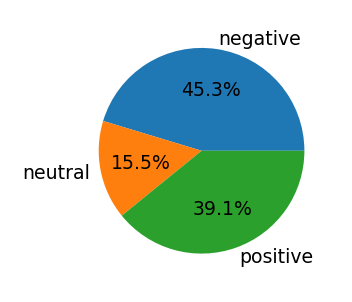

In [12]:
#train data:

data=train_df.LABEL.value_counts(sort=0)
plt.figure(figsize=(1.5,1.5), dpi=227)
plt.pie(data, labels=labels, textprops={'fontsize':6}, startangle=0, autopct='%1.1f%%')
plt.show

<function matplotlib.pyplot.show>

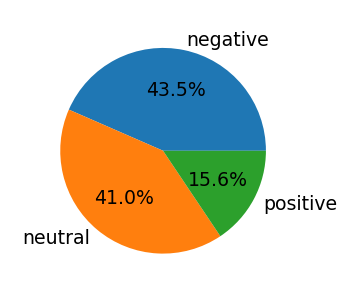

In [13]:
#val data:

data=val_df.LABEL.value_counts(sort=0)
plt.figure(figsize=(1.5,1.5), dpi=227)
plt.pie(data, labels=labels, textprops={'fontsize':6}, startangle=0, autopct='%1.1f%%')
plt.show

<function matplotlib.pyplot.show>

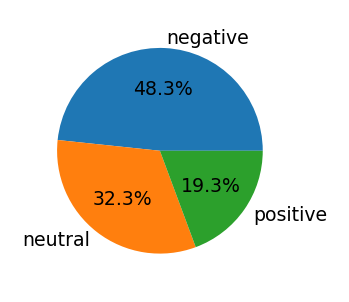

In [14]:
#test data:

data=test_df.LABEL.value_counts(sort=0)
plt.figure(figsize=(1.5,1.5), dpi=227)
plt.pie(data, labels=labels, textprops={'fontsize':6}, startangle=0, autopct='%1.1f%%')
plt.show

In [15]:
df_grouped=train_df[['LABEL','TWEET']].groupby(by='LABEL').agg(lambda x:' '.join(x))
df_grouped

,TWEET
LABEL,
0,disappointed wwe summerslam want see john cena...
1,ben smith smith concussion remains lineup thur...
2,qt original draft book remus lupin survived ba...


In [18]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(analyzer='word')
data=cv.fit_transform(df_grouped['TWEET'])
df_dtm = pd.DataFrame(data.toarray(), columns=cv.get_feature_names())
df_dtm.index=df_grouped.index

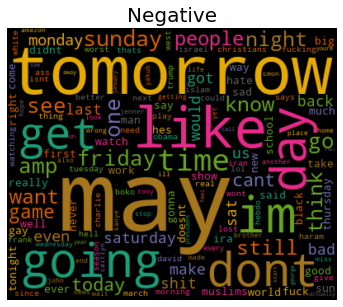

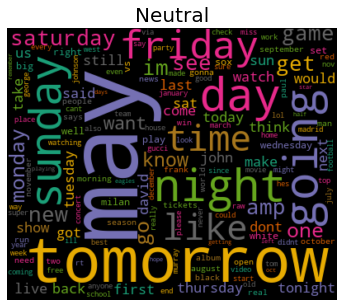

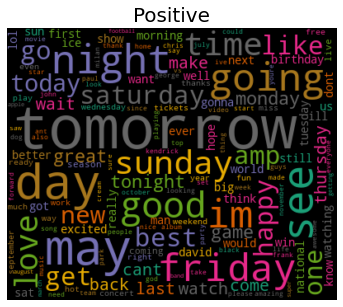

In [19]:
# Function for generating word clouds
def generate_wordcloud(data,title):
  wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(data)
  plt.figure(figsize=(6,5))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  if title=='0':
    tit = "Negative"
  if title=='1':
    tit = "Neutral"
  if title=='2':
    tit = "Positive"
  plt.title('\n'.join(wrap(tit,60)),fontsize=20)
  plt.show()
  
# Transposing document term matrix
df_dtm=df_dtm.transpose()

# Plotting word cloud for each product
for index,product in enumerate(df_dtm.columns):
  generate_wordcloud(df_dtm[product].sort_values(ascending=False),product)

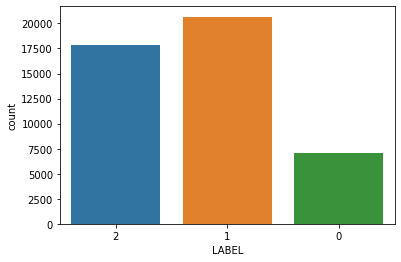

In [20]:
import seaborn as sns
sns.countplot(x = train_df['LABEL'], data = train_df)

In [21]:
#rounding off the data set based on the batch size 
train_df = train_df[:45479]
val_df = val_df[:1842]

In [22]:
train_df.LABEL.value_counts()

1    20612
2    17795
0     7072
Name: LABEL, dtype: int64

# Formating the data to add in Model - XLNet

In [23]:
# XLNet need [SEP] [CLS] tags at the end of each sentence

def sep_cls(df):
  TWEETS  = []
  for TWEET in df['TWEET']:
    TWEET = TWEET+"[SEP] [CLS]"
    TWEETS.append(TWEET)
  return TWEETS

In [24]:
train_tweet = sep_cls(train_df)
val_tweet = sep_cls(val_df)
test_tweet = sep_cls(test_df)

In [25]:
len(train_tweet)

45479

In [26]:
# XLNet tokenizer is used to convert our text into tokens that correspond to XLNet’s vocabulary

tokenizer  = XLNetTokenizer.from_pretrained('xlnet-base-cased',do_lower_case=True)
train_tokenized_text = [tokenizer.tokenize(tw) for tw in train_tweet]
val_tokenized_text = [tokenizer.tokenize(tw) for tw in val_tweet]
test_tokenized_text = [tokenizer.tokenize(tw) for tw in test_tweet]

100%|██████████| 798011/798011 [00:00<00:00, 25057650.55B/s]


In [27]:
# converting the tokens into ids

train_ids = [tokenizer.convert_tokens_to_ids(x) for x in train_tokenized_text]
val_ids = [tokenizer.convert_tokens_to_ids(x) for x in val_tokenized_text]
test_ids = [tokenizer.convert_tokens_to_ids(x) for x in test_tokenized_text]

In [28]:
train_df['LABEL'] = train_df['LABEL'].astype(int)
train_label = train_df['LABEL'].values
val_df['LABEL'] = val_df['LABEL'].astype(int)
val_label = val_df['LABEL'].values
test_df['LABEL'] = test_df['LABEL'].astype(int)
test_label = test_df['LABEL'].values

In [29]:
# function to find the maximum length  of the ids

def max(ids):
  max1 = len(ids[0])
  for i in ids:
    if(len(i)>max1):
      max1=len(i)
  MAX_LEN = max1
  return MAX_LEN

In [30]:
train_max = max(train_ids)
val_max = max(val_ids)
test_max = max(test_ids)

In [31]:
# padding our sentences

train_ids2 = pad_sequences(train_ids,maxlen=train_max,dtype="long",truncating="post",padding="post")
val_ids2 = pad_sequences(val_ids,maxlen=val_max,dtype="long",truncating="post",padding="post")
test_ids2 = pad_sequences(test_ids,maxlen=test_max,dtype="long",truncating="post",padding="post")

In [32]:
# balancing the data based on the number of labels - undersampling

nm = RandomUnderSampler(random_state=42)
x_train, y_train = nm.fit_resample(train_ids2,train_label)
x_val, y_val = nm.fit_resample(val_ids2,val_label)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [33]:
# balanced dataset

print(format(Counter(train_label)))
print(format(Counter(y_train)))

Counter({1: 20612, 2: 17795, 0: 7072})
Counter({0: 7072, 1: 7072, 2: 7072})


In [34]:
xtrain = x_train
ytrain = y_train
xval = x_val
yval = y_val
xtest = test_ids2
ytest = test_label

In [35]:
Xtrain = torch.tensor(xtrain)
Ytrain = torch.tensor(ytrain)
Xval = torch.tensor(xval)
Yval = torch.tensor(yval)
Xtest = torch.tensor(xtest)
Ytest = torch.tensor(ytest)

In [36]:
# batch size

batch_size = 32

In [37]:
# finalyzing the dataloader

train_data = TensorDataset(Xtrain,Ytrain)
val_data = TensorDataset(Xval,Yval)
test_data = TensorDataset(Xtest,Ytest)
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True,worker_init_fn=np.random.seed(0))
val_loader = DataLoader(val_data,batch_size=batch_size,shuffle=True,worker_init_fn=np.random.seed(0))
test_loader = DataLoader(test_data,batch_size=batch_size,shuffle=True,worker_init_fn=np.random.seed(0))

# Model - XLNet

In [38]:
# initializing the model

model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased",num_labels=3)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [39]:
# check the device for GPU

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [40]:
model.to(device)

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

In [41]:
# Adam optimizer is used with learniing rate

optimizer = AdamW(model.parameters(),lr=2e-5)
criterion = nn.CrossEntropyLoss()

In [42]:
# function to determine the accuracy

def flat_accuracy(preds,labels):  # A function to predict Accuracy
  correct=0
  for i in range(0,len(labels)):
    if(preds[i]==labels[i]):
      correct+=1
  return (correct/len(labels))*100


# Training and Validating the Model

In [43]:
no_train = 0
no_val = 0
epochs = 10
min_valid_loss = np.inf
for epoch in range(epochs):
  torch.manual_seed(42)
  model.train()
  loss1 = []
  steps = 0
  train_loss = []
  l = []
  l1 = []
  val_loss=[]
  i=1
  for inputs,labels1 in train_loader :
    inputs.to(device)
    labels1.to(device)
    optimizer.zero_grad()
    outputs = model(inputs.to(device))
    loss = criterion(outputs[0],labels1.to(device)).to(device)
    logits = outputs[0]
    #ll=outp(loss)
    [train_loss.append(p.item()) for p in torch.argmax(outputs[0],1).flatten() ]#our predicted 
    [l.append(z.item()) for z in labels1]# real labels
    loss.backward()
    optimizer.step()
    train_losss = loss.item() * inputs.size(0)
    loss1.append(loss.item())
    no_train += inputs.size(0)
    steps += 1
  
  valid_loss = 0.0
  
  model.eval()
  for data, labels2 in val_loader:
    data.to(device)
    labels2.to(device)
    target = model(data.to(device))
    logits = target[0]
    v_loss = criterion(target[0],labels2.to(device)).to(device)
    [val_loss.append(p.item()) for p in torch.argmax(target[0], 1).flatten() ]#our predicted 
    [l1.append(z.item()) for z in labels2]# real labels
    #logits = target[0]
    no_val += data.size(0)

    valid_loss = loss.item() * data.size(0)

  print(f'Epoch {epoch}')
  print("Current Train Loss is : {} Step is : {} number of Example : {} Train Accuracy : {}".format(loss.item(),epoch,no_train,flat_accuracy(train_loss,l)))
  print("Current Val Loss is : {} Step is : {} number of Example : {} Val Accuracy : {}".format(v_loss.item(),epoch,no_val,flat_accuracy(val_loss,l1)))
  torch.save(model.state_dict(), 'sentiment_model.pth')

/usr/local/lib/python3.7/dist-packages/pytorch_transformers/optimization.py:166: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1005.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


Epoch 0
Current Train Loss is : 0.6901025772094727 Step is : 0 number of Example : 21216 Train Accuracy : 55.43457767722474
Current Val Loss is : 1.2142744064331055 Step is : 0 number of Example : 864 Val Accuracy : 61.111111111111114
Epoch 1
Current Train Loss is : 0.49188923835754395 Step is : 1 number of Example : 42432 Train Accuracy : 74.86331070889895
Current Val Loss is : 1.3013557195663452 Step is : 1 number of Example : 1728 Val Accuracy : 64.4675925925926
Epoch 2
Current Train Loss is : 0.03966003283858299 Step is : 2 number of Example : 63648 Train Accuracy : 89.1826923076923
Current Val Loss is : 1.6468970775604248 Step is : 2 number of Example : 2592 Val Accuracy : 62.03703703703704
Epoch 3
Current Train Loss is : 0.018345965072512627 Step is : 3 number of Example : 84864 Train Accuracy : 94.78223981900452
Current Val Loss is : 1.947149395942688 Step is : 3 number of Example : 3456 Val Accuracy : 63.07870370370371
Epoch 4
Current Train Loss is : 0.004871021490544081 Step i

In [44]:
# loading the saved model

model.load_state_dict(torch.load('sentiment_model.pth'))

<All keys matched successfully>

# Testing our Model

In [46]:
# Testing our Model
model.eval()
acc = []
lab = []
t = 0
for inp,lab1 in test_loader:
  inp.to(device)
  lab1.to(device)
  t+=lab1.size(0)
  outp1 = model(inp.to(device))
  [acc.append(p1.item()) for p1 in torch.argmax(outp1[0],axis=1).flatten() ]
  [lab.append(z1.item()) for z1 in lab1]
print("Total Examples : {} Test Accuracy {}".format(t,flat_accuracy(acc,lab)))

Total Examples : 12284 Test Accuracy 69.49886030608922
